In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import torch.nn.functional as F
from diffusers import DDPMScheduler

#loading module
import dataset
import model
import importlib
importlib.reload(dataset)
importlib.reload(model)

from model import Unet1D
from dataset import FlowDataset, NoiseBank
# Global Configuration
class Config:
    N_SAMPLES = 200_000  
    ACC_LIMIT = 50.0
    NUM_PTS = 32
    DIM = 3
    DEGREE = 5
    TOTAL_TIME = 1.0
    
    #Hyperparameters
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 1024
    LR = 1e-4
    EPOCHS  =5000
    # Path
    DATA_PATH = f"dataset_training/dataset_final_pts{NUM_PTS}.npz" 
    
    # Noise
    NOISE_BANK_PATH = f"dataset_training/noise_bank_{N_SAMPLES // 1000}k_pts{NUM_PTS}.npz"

    # CFG
    NUM_CLASSES = 3   # 0:top, 1:side, 2:bottom
    P_UNCOND = 0.1   
    GUIDANCE_W = 1.0  
    
    # Model parameters
    MODEL_DIM = 3         
    MODEL_CHANNELS = 32   
    MODEL_MULTS = (1, 2, 4) 

cfg = Config()


print(f" Device: {cfg.DEVICE}")
print(f" Data Path: {cfg.DATA_PATH}")
print(f" CFG Setup: Classes={cfg.NUM_CLASSES}, DropRate={cfg.P_UNCOND}")

 Device: cuda
 Data Path: dataset_training/dataset_final_pts32.npz
 CFG Setup: Classes=3, DropRate=0.1


In [2]:
print(f" Generating {cfg.N_SAMPLES} noise data points using the script...")
print("This may take a few minutes. Please monitor the progress bar output below.")
!python generate_noise_bank.py \
    --data_path "{cfg.DATA_PATH}" \
    --save_path "{cfg.NOISE_BANK_PATH}" \
    --n_samples {cfg.N_SAMPLES} \
    --limit {cfg.ACC_LIMIT} \
    --n_cps {cfg.NUM_PTS} \
    --dim {cfg.DIM} \
    --time {cfg.TOTAL_TIME} \
    --cores -1 \
    --std_factor 1 #this factor is standard factor, means Gaussian Std = 1/facor,we use Z-Score ,need not use it.
print("Noise Bank Complete!")

 Generating 200000 noise data points using the script...
This may take a few minutes. Please monitor the progress bar output below.
[Noise Bank Generator] Start...
Statistics loaded. Shape: (3072, 32, 3)
⚙️ Using 126 CPU cores.
Generating: 100%|███████████████████| 200000/200000 [03:01<00:00, 1103.51traj/s]

DATA STATISTICS REPORT
--------------------------------------------------
1. Original Data ((3072, 32, 3)):
   - Mean: 3.139069
   - Std:  1.974056
2. Raw Noise (Factor=1.0):
   - Mean: 3.138589
   - Std:  1.974214
3. Projected Noise:
   - Mean: 3.138590
   - Std:  1.784877

Packing data...
Saved to: dataset_training/noise_bank_200k_pts32.npz
Noise Bank Complete!


In [3]:
def train_model(mode_name, noise_bank, dataset):
    print(f"\n Start Training: [{mode_name}]")
    loader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)

    model = Unet1D(
        input_dim=cfg.MODEL_DIM,
        base_channels=cfg.MODEL_CHANNELS,
        dim_mults=cfg.MODEL_MULTS,
        num_classes=cfg.NUM_CLASSES
    ).to(cfg.DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LR)
    model.train()
    
    pbar = tqdm(range(cfg.EPOCHS), desc=f"Training {mode_name}")
    for epoch in pbar:
        epoch_loss = 0
        for x1, label in loader:
            x1, label = x1.to(cfg.DEVICE), label.to(cfg.DEVICE)
            
            # Noise Bank Sampling
            x0 = noise_bank.sample(x1.shape[0])
            
            t = torch.rand(x1.shape[0], device=cfg.DEVICE)
            t_exp = t.view(-1, 1, 1)
            
            x_t = (1 - t_exp) * x0 + t_exp * x1
            u_t = x1 - x0
            
            v_pred = model(x_t, t, cond=label)
            loss = torch.mean((v_pred - u_t) ** 2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x1.shape[0]
            
        avg_loss = epoch_loss / len(dataset)
        if epoch % 50 == 0:
            pbar.set_postfix({"Loss": f"{avg_loss:.6f}"})
            
    return model

In [4]:
#Training all model

dataset_train = FlowDataset(cfg.DATA_PATH, p_uncond=cfg.P_UNCOND, num_classes=cfg.NUM_CLASSES)

noise_bank_raw = NoiseBank(cfg.NOISE_BANK_PATH, normalizer=dataset_train.normalizer, mode='baseline', device=cfg.DEVICE)
noise_bank_proj = NoiseBank(cfg.NOISE_BANK_PATH, normalizer=dataset_train.normalizer, mode='ours', device=cfg.DEVICE)

# Baseline (Flow Matching) 
print("\n" + "="*40)
print("1. Training Flow Matching (Baseline: Raw Noise)")
print("="*40)
model_baseline = train_model('Baseline_FM', noise_bank_raw, dataset_train)

# Ours (Flow Matching)
print("\n" + "="*40)
print("2. Training Flow Matching (Ours: Projected Noise)")
print("="*40)
model_ours = train_model('Ours_FM', noise_bank_proj, dataset_train)
print("\n All Models Trained Successfully!")

   FlowDataset initialized.
   Stats Mean: [4.001167  2.6480095 2.768032 ]
   Stats Std:  [2.8195844  0.66199887 1.4800013 ]
 NoiseBank (baseline) loaded & normalized. Shape: torch.Size([200000, 3, 32])
 NoiseBank (ours) loaded & normalized. Shape: torch.Size([200000, 3, 32])

1. Training Flow Matching (Baseline: Raw Noise)

 Start Training: [Baseline_FM]


Training Baseline_FM:   0%|          | 0/5000 [00:00<?, ?it/s]


2. Training Flow Matching (Ours: Projected Noise)

 Start Training: [Ours_FM]


Training Ours_FM:   0%|          | 0/5000 [00:00<?, ?it/s]


 All Models Trained Successfully!


In [5]:
#save model
import os
import torch
import time

def save_all_experiment_models(save_dir="saved_models"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    print(f" Saving 3 models with timestamp: {timestamp}")

    real_config_dict = {
        k: getattr(cfg, k) 
        for k in dir(cfg) 
        if not k.startswith('__') and not callable(getattr(cfg, k))
    }
    
    print(f" Config captured: {list(real_config_dict.keys())}")

    models_map = {
        "fm_baseline": model_baseline,
        "fm_ours_qp":  model_ours,
    }
    
    for name, model_obj in models_map.items():
        save_path = os.path.join(save_dir, f"{name}_pts{cfg.NUM_PTS}_{timestamp}.pth")

        checkpoint = {
            'model_state_dict': model_obj.state_dict(),
            'config': real_config_dict, 
            'timestamp': timestamp,
            'model_type': name
        }
        
        torch.save(checkpoint, save_path)
        
        file_size = os.path.getsize(save_path) / 1024 / 1024
        print(f"   Saved [{name:<12}] -> {save_path} ({file_size:.2f} MB)")
    return timestamp
current_ts = save_all_experiment_models()

 Saving 3 models with timestamp: 20260130_165643
 Config captured: ['ACC_LIMIT', 'BATCH_SIZE', 'DATA_PATH', 'DEGREE', 'DEVICE', 'DIM', 'EPOCHS', 'GUIDANCE_W', 'LR', 'MODEL_CHANNELS', 'MODEL_DIM', 'MODEL_MULTS', 'NOISE_BANK_PATH', 'NUM_CLASSES', 'NUM_PTS', 'N_SAMPLES', 'P_UNCOND', 'TOTAL_TIME']
   Saved [fm_baseline ] -> saved_models/fm_baseline_pts32_20260130_165643.pth (2.73 MB)
   Saved [fm_ours_qp  ] -> saved_models/fm_ours_qp_pts32_20260130_165643.pth (2.73 MB)


Sample 222...
⚡ [Backend] Generating Data (Sample=222)...
   FlowDataset initialized.
   Stats Mean: [4.001167  2.6480095 2.768032 ]
   Stats Std:  [2.8195844  0.66199887 1.4800013 ]
   [Model] Load: fm_baseline_pts32_20260130_165643.pth
   [Model] Load: fm_ours_qp_pts32_20260130_165643.pth
Completed! Save to  viz_final_sample222.png


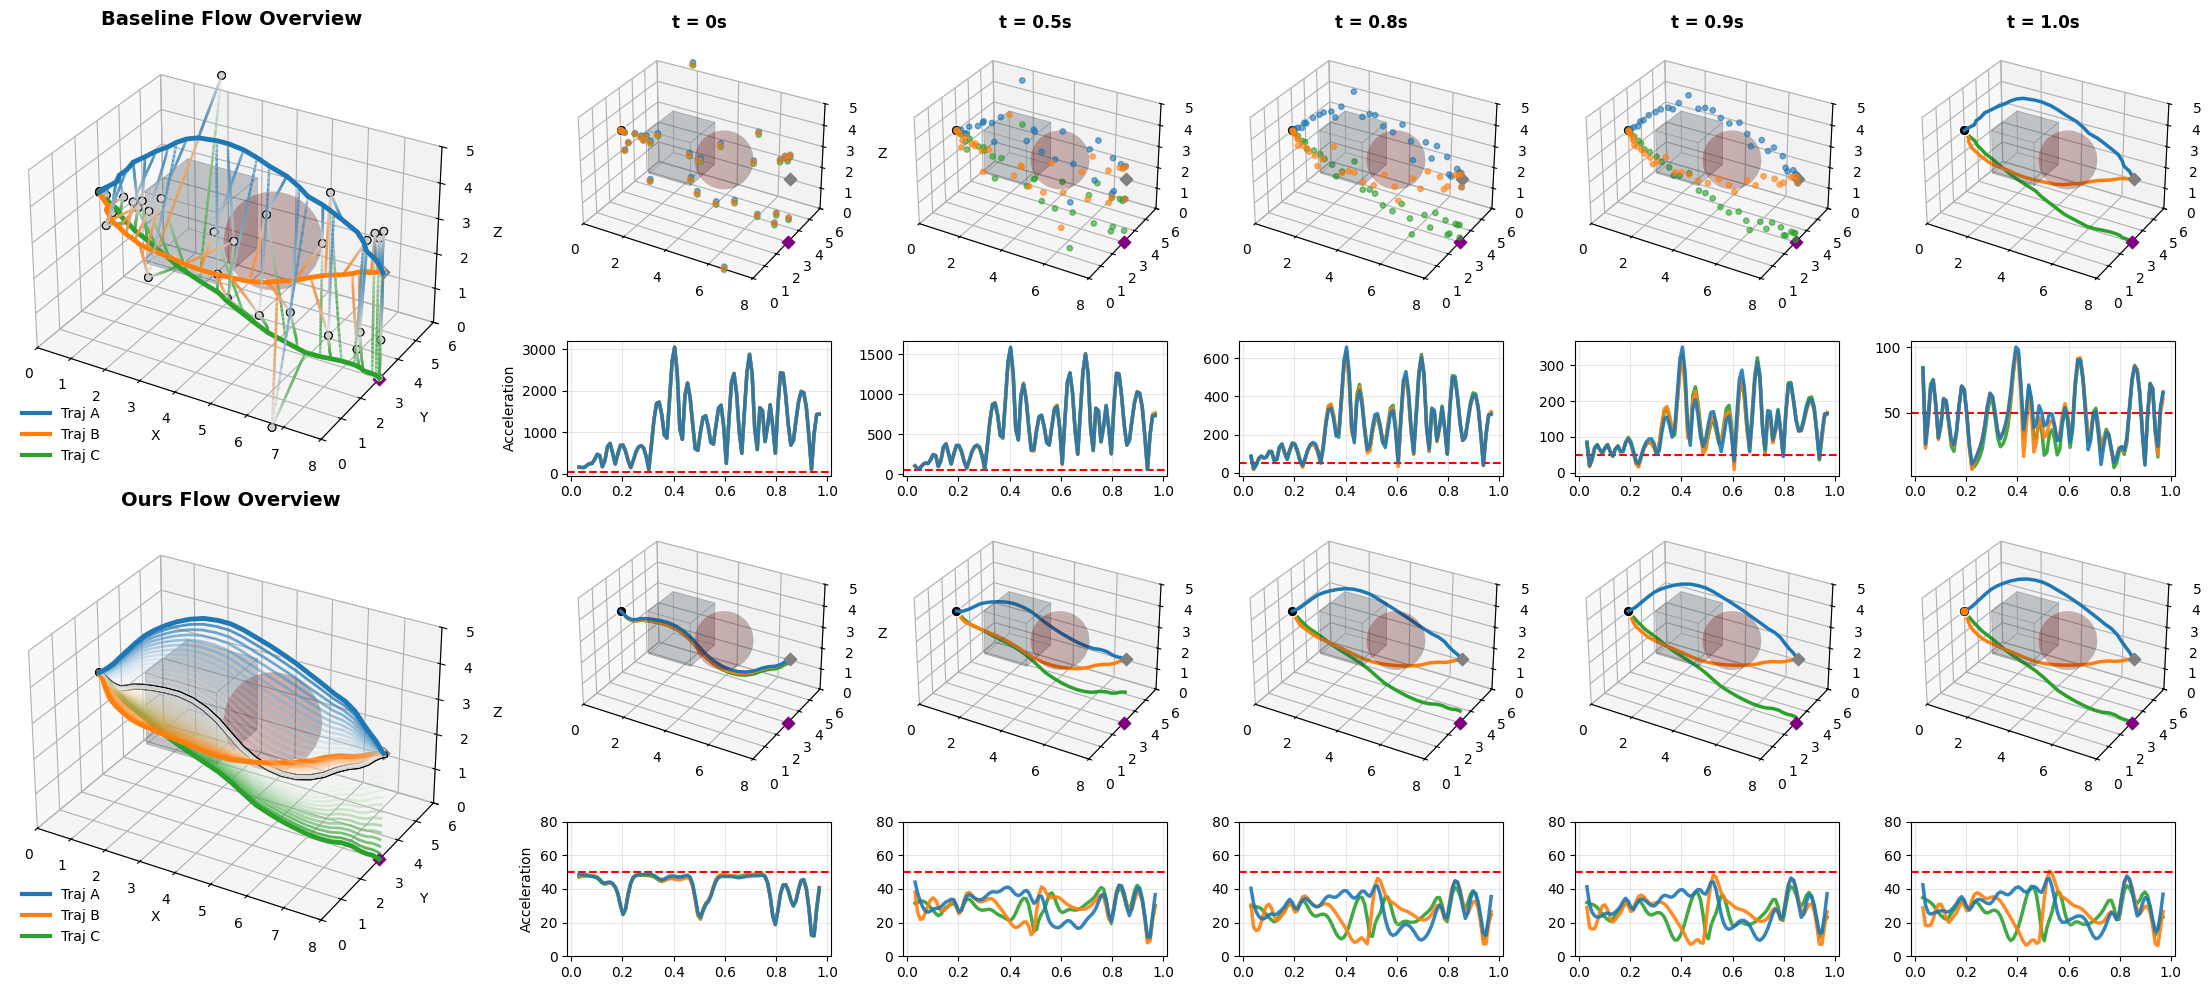

In [8]:
#visualization
import run_visual
my_viz_config = {
    "DATASET_PATH": cfg.DATA_PATH,
    "NOISE_BANK_PATH": cfg.NOISE_BANK_PATH,
    "DEVICE": str(cfg.DEVICE),   
    "ACC_LIMIT":cfg.ACC_LIMIT,
    #visual  parameters
    "SAMPLE_IDX": 222, #seed  
    "STEPS": 30,         
    "SLICE_INDICES": [1, 15, 24, 27, 30] # t = indice/Steps ,for visualization purposes, we replaced the time t=0 with 1/40. 
}

print(f"Sample {my_viz_config['SAMPLE_IDX']}...")
run_visual.main(my_viz_config)